### Problema de Negócios - Séries Temporais
- Prever valores futuros do índice BSESN (indiano)
- Utilizar notícias (variáveis exógenas) para ver se melhora o desempenho do modelo

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import yfinance as yf

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from textblob import TextBlob

from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Versões utilizadas
%reload_ext watermark
%watermark -a "Case 09 - Séries Temporais" --iversions

Author: Case 09 - Séries Temporais

statsmodels: 0.14.1
sklearn    : 1.4.2
torch      : 2.5.0
pmdarima   : 2.0.4
numpy      : 1.26.4
nltk       : 3.9.1
pandas     : 2.2.2
textblob   : 0.17.1
optuna     : 4.0.0
matplotlib : 3.8.4
yfinance   : 0.2.55



#### Download do índice BSESN

In [3]:
# symbol = "^BSESN"
# start_date = "2005-01-03"
# end_date = "2019-11-30"

# df_bsesn = yf.download(symbol, start=start_date, end=end_date)
# df_bsesn.index = pd.to_datetime(df_bsesn.index)
# display(df_bsesn.head())
# print()
# display(df_bsesn.tail())
# df_bsesn.shape

# df_bsesn.to_csv('datasets/bsesn.csv')

In [4]:
df_bsesn = pd.read_csv('datasets/bsesn.csv', index_col='Date', parse_dates=['Date'])

In [5]:
df_bsesn.describe()

,Close,High,Low,Open,Volume
count,3659.000000,3659.000000,3659.000000,3659.000000,3.659000e+03
mean,21120.514294,21265.444089,20981.010770,21142.528093,1.036641e+05
std,8729.597835,8755.229302,8712.370373,8745.451344,1.236470e+06
min,6102.740234,6174.000000,6069.330078,6093.660156,8.000000e+02
25%,15164.030273,15333.915039,15011.270020,15195.280273,1.060000e+04
50%,19013.699219,19194.460938,18845.310547,19034.000000,1.420000e+04
75%,27569.160156,27753.500000,27429.995117,27631.935547,2.000000e+04
max,41130.171875,41163.789062,40996.078125,41161.539062,3.181510e+07


In [6]:
# Verificando os missing values
df_bsesn.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Text(0, 0.5, 'BSESN')

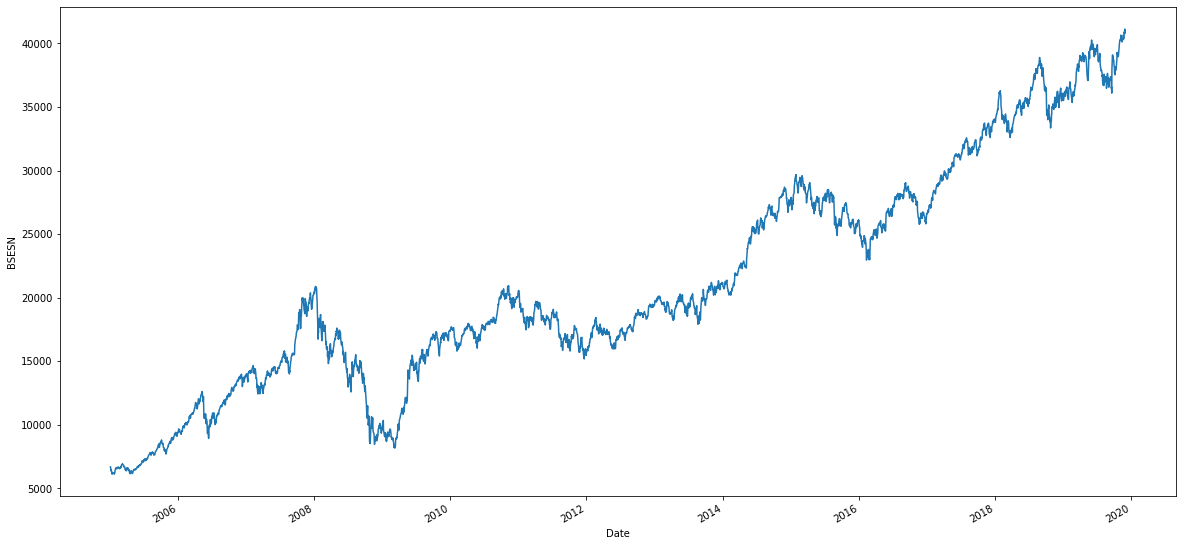

In [7]:
# Plot
plt.figure(figsize = (20,10))
df_bsesn['Close'].plot()
plt.ylabel('BSESN')

### Decomposição

In [8]:
df_bsesn_decomp = df_bsesn['Close']
df_bsesn_decomp.index = pd.to_datetime(df_bsesn_decomp.index)
df_bsesn_decomp = df_bsesn_decomp.resample('W').mean() # formato semanal

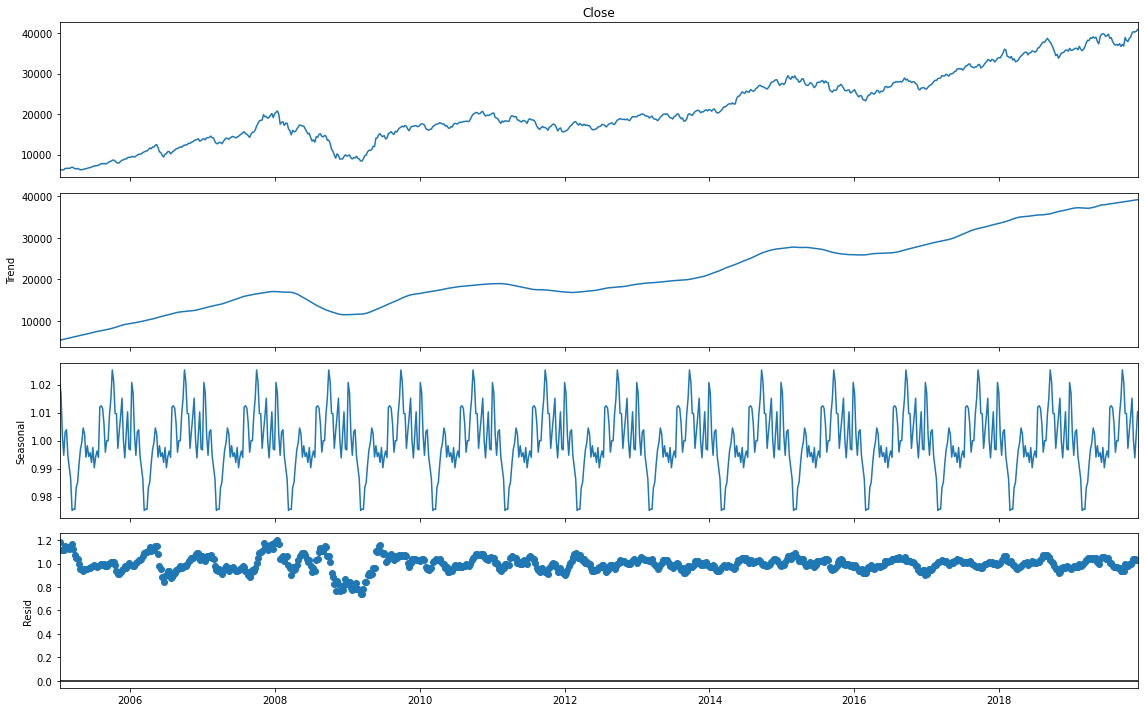

In [9]:
decomposicao_mult = seasonal_decompose(df_bsesn_decomp,
                                       model='multiplicative',
                                       extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_mult.plot()
plt.show()

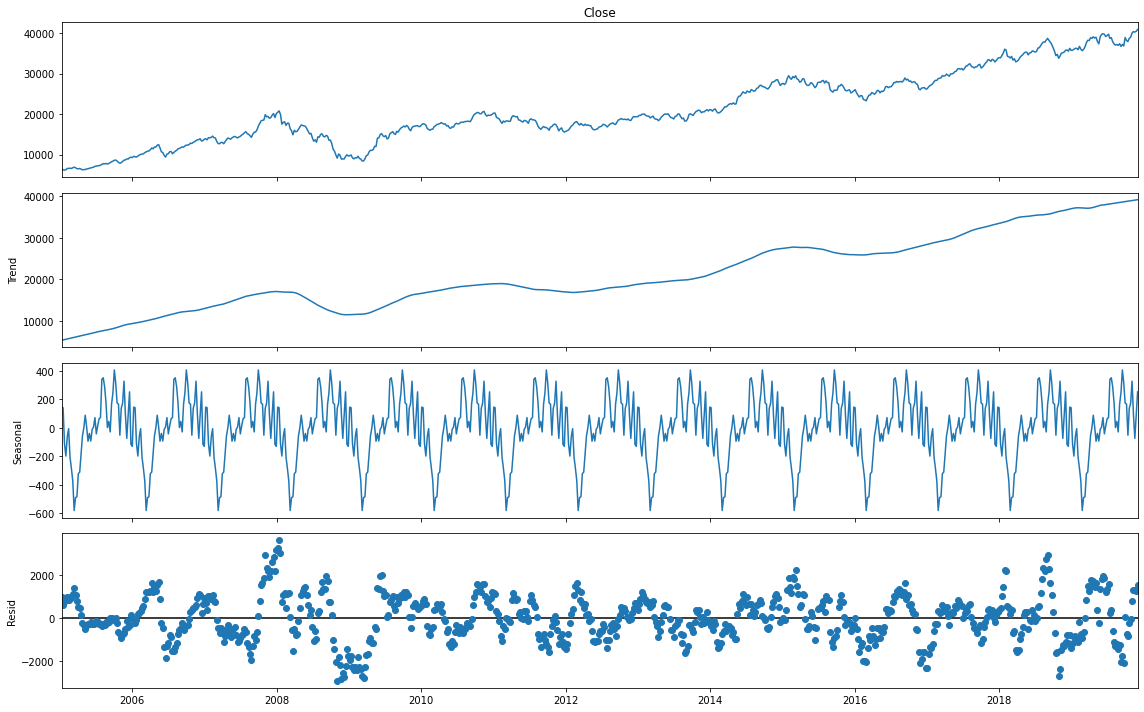

In [10]:
decomposicao_adt = seasonal_decompose(df_bsesn_decomp,
                                       model='aditive',
                                       extrapolate_trend='freq')

plt.rcParams.update({'figure.figsize': (16,10)})
decomposicao_adt.plot()
plt.show()

A decomposição aditiva capturou o ruído e preciso que sejam aleatórios, então usarei a multiplicativa para observar melhor os dados. Além disso, é possível observar uma tendência de alta e as semanas do ano que ocorrem os principais picos.

In [11]:
df_bsesn_decomp = pd.concat([decomposicao_mult.seasonal,
                             decomposicao_mult.trend,
                             decomposicao_mult.resid,
                             decomposicao_mult.observed], axis=1)

In [12]:
df_bsesn_decomp

,seasonal,trend,resid,Close
Date,,,,
2005-01-09,1.020730,5374.976171,1.187551,6515.379980
2005-01-16,1.016979,5452.403701,1.119175,6205.806055
2005-01-23,1.002018,5529.831231,1.116361,6185.744995
2005-01-30,0.994764,5607.258762,1.117263,6231.982544
2005-02-06,1.003065,5684.686292,1.153141,6575.334082
...,...,...,...,...
2019-11-03,1.015119,38946.839028,1.012868,40044.448242
2019-11-10,1.000157,38997.823622,1.035779,40399.464063
2019-11-17,0.993836,39048.808217,1.037827,40276.077148


#### Plot da Média Móvel
- Visualizar o comportamento da média e da variabilidade (volatilidade) ao longo do tempo
- Ver se houve quebra de padrão

In [13]:
close = df_bsesn['Close']

In [14]:
# Calcula as estatísticas móveis
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

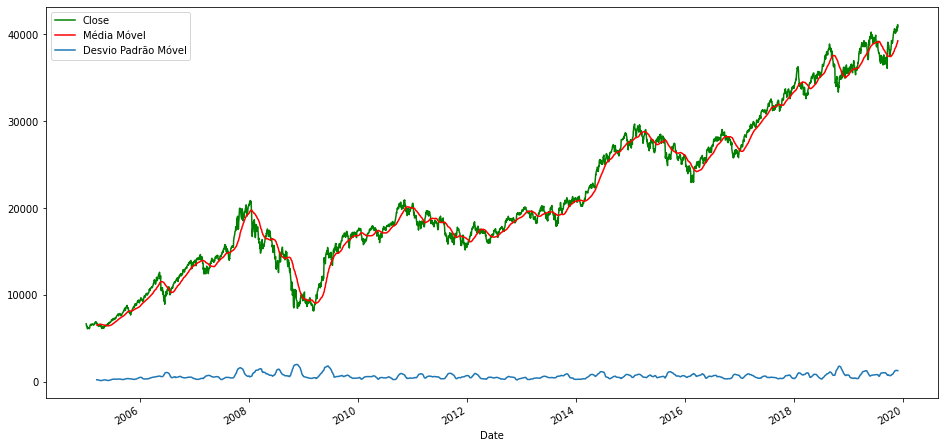

In [15]:
plt.figure(figsize = (16,8))
df_bsesn['Close'].plot(color = 'g', label = 'Close')
ma.plot(color = 'r', label = 'Média Móvel')
std.plot(label = 'Desvio Padrão Móvel')
plt.legend()

#### Train e Test em Séries Temporais
- Série Temporal não pode ter divisão aleatória com train, test e split
- A ordem importa

In [16]:
dados_treino = df_bsesn[:3000]
dados_teste = df_bsesn[3000:]

In [17]:
dados_treino.shape

(3000, 5)

In [18]:
dados_teste.shape

(659, 5)

#### Testando a Estacionaridade
- Objetivo: média e variância constantes

In [19]:
# Função para testar a estacionaridade
def testa_estacionaridade(ts):

    # Calcula as estatísticas móveis
    rolmean = ts.rolling(20).mean()
    rolstd = ts.rolling(20).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (18,9))
    plt.plot(ts, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'r', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.xlabel('Data')
    plt.legend()
    plt.title('Estatísticas Móveis',  fontsize = 30)
    plt.show(block = False)
 
    print('Resultados do Teste Dickey Fuller:')
    result = adfuller(ts, autolag = 'AIC')
    labels = ['ADF Test Statistic', 'Valor-p', 'Número de Lags', 'Número de Observações']
    
    for value,label in zip(result, labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.")
    else:
        print("Evidência fraca contra hipótese nula. Série temporal não é estacionária.")

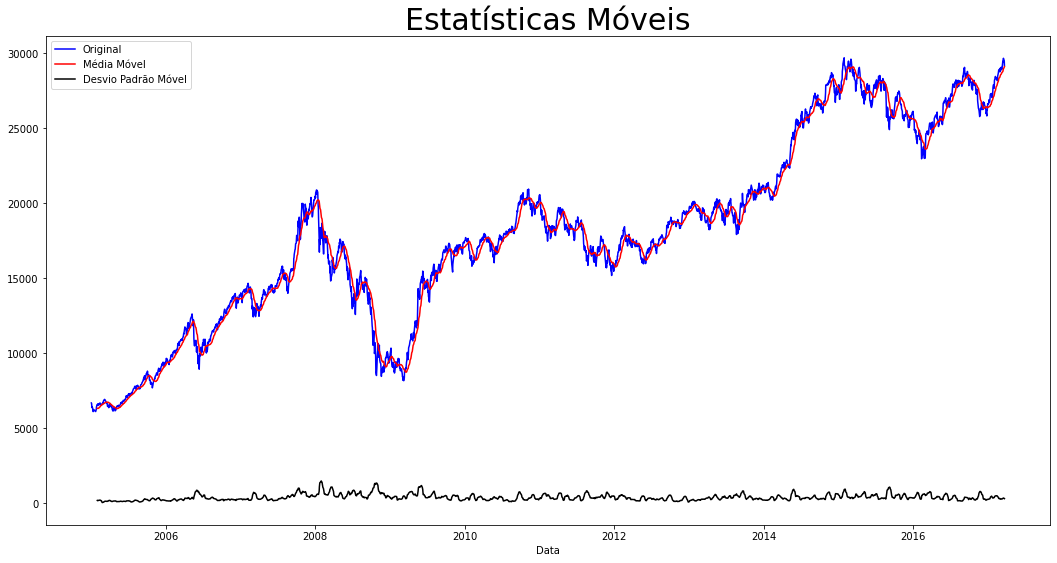

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -1.1019822871694875
Valor-p : 0.7142807448591939
Número de Lags : 5
Número de Observações : 2994
Evidência fraca contra hipótese nula. Série temporal não é estacionária.


In [20]:
testa_estacionaridade(dados_treino['Close'])

Série temporal não é estacionária, vou aplicar transformação de log aos dados.

#### Transformação de Log
Reduz a heterocedasticidade (mudança de variância) para poder linearizar a série. Fica melhor para modelagem estatística

In [21]:
# Aplica transformação de log
dados_treino_log = np.log(dados_treino['Close']) 
dados_teste_log = np.log(dados_teste['Close'])

In [22]:
# Média móvel
media_movel = dados_treino_log.rolling(24).mean() 

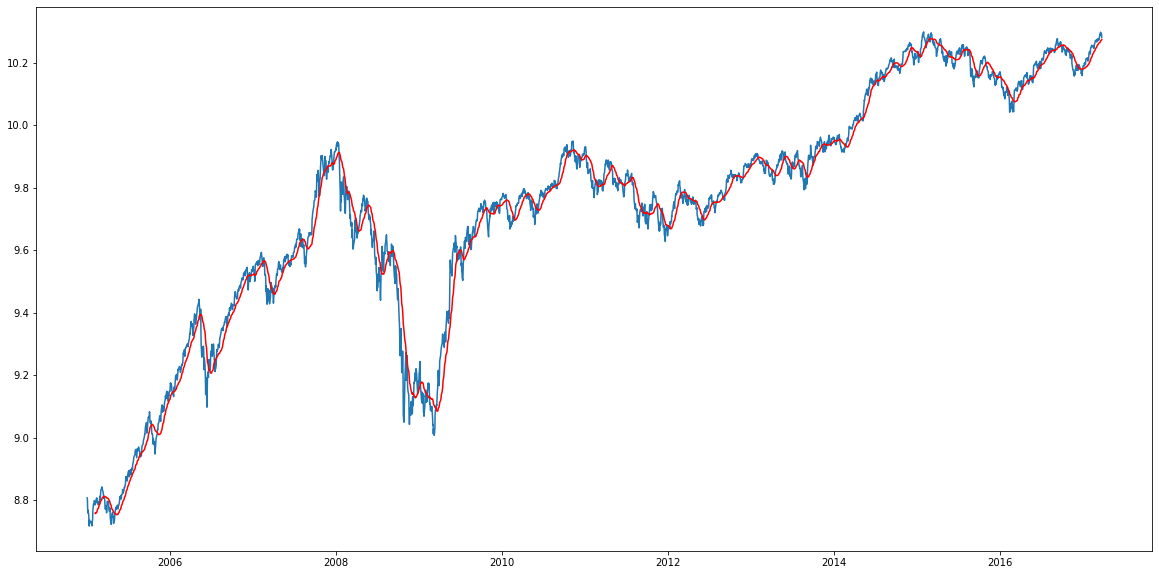

In [23]:
plt.figure(figsize = (20,10))
plt.plot(dados_treino_log) 
plt.plot(media_movel, color = 'red')

In [24]:
# Drop de valores NA
dados_treino_log.dropna(inplace = True)
dados_teste_log.dropna(inplace = True)

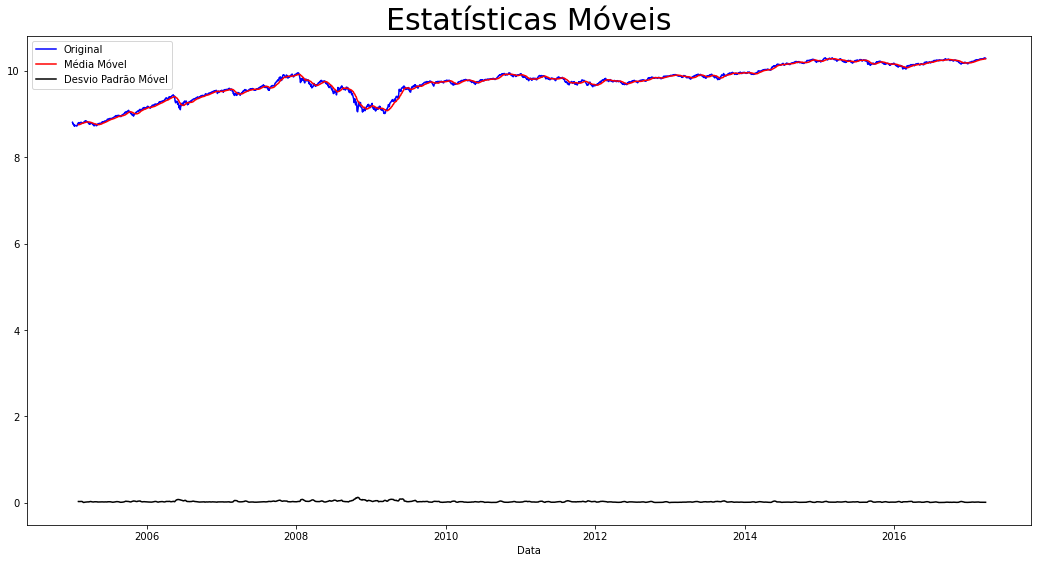

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -2.0687606019698648
Valor-p : 0.2572601828927352
Número de Lags : 4
Número de Observações : 2995
Evidência fraca contra hipótese nula. Série temporal não é estacionária.


In [25]:
testa_estacionaridade(dados_treino_log)

Série ainda não estacionária, vou visualizar por outro ângulo.

#### Diferença Log - Média Móvel
Remove a tendência de longo prazo de uma forma mais suave que uma diferenciação simples

In [26]:
# Calcula a diferença entre log e media_movel
dados_treino_log_diff = dados_treino_log - media_movel
dados_treino_log_diff.dropna(inplace = True)

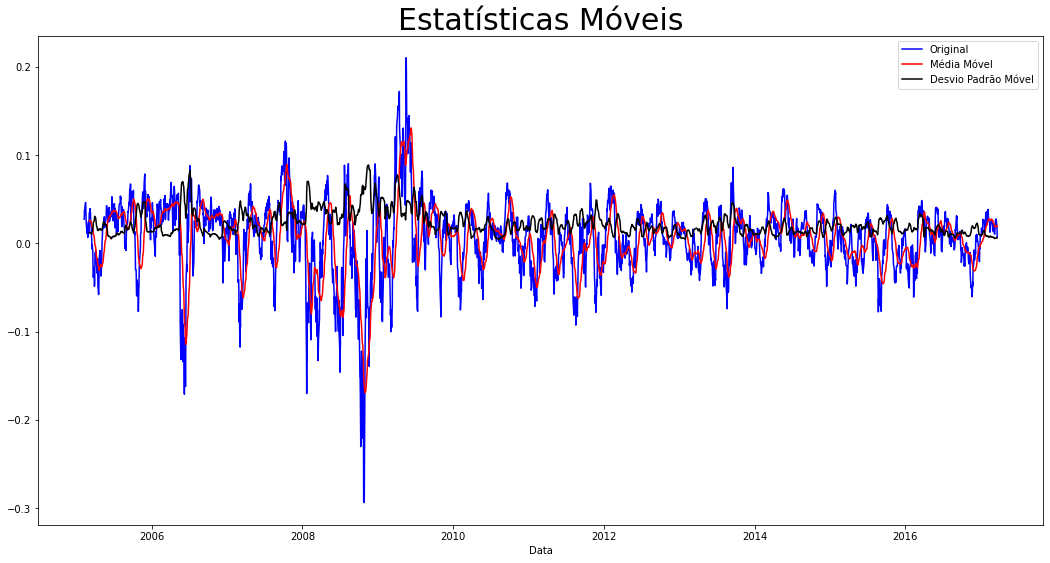

Resultados do Teste Dickey Fuller:
ADF Test Statistic : -8.103714319361723
Valor-p : 1.2794404681746443e-12
Número de Lags : 22
Número de Observações : 2954
Evidências fortes para rejeitar a hipótese nula (H0). Os dados são estacionários.


In [27]:
testa_estacionaridade(dados_treino_log_diff)

#### Lollipop
- p: ordem autoregressiva (quantos valores passados são usados para prever o próximo)
- d: número de diferenciações para tornar a série estacionária
- q: ordem da média móvel (erros passados que ajudam a prever o atual)
- P: ordem autogressiva sazonal
- D: grau de diferenciação
- Q: ordem da média móvel sazonal
- M: períodos da sazonalidade

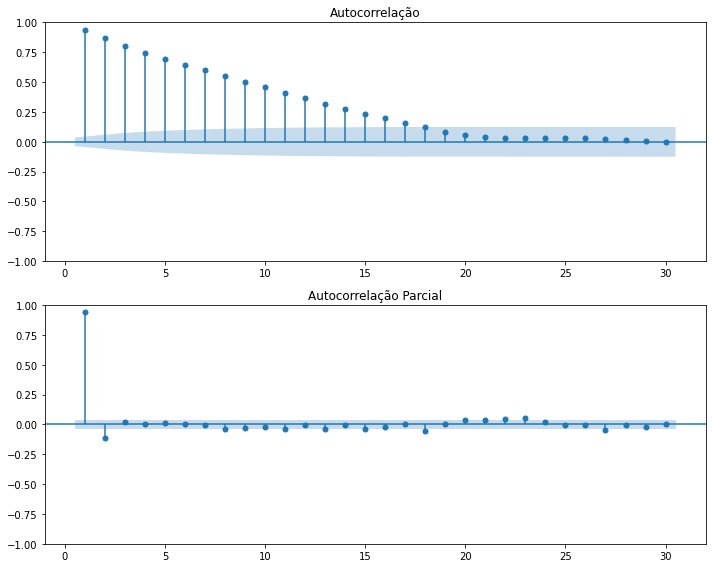

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(dados_treino_log_diff, lags=30, zero=False, ax=axes[0])
axes[0].set_title("Autocorrelação")

# Gráfico PACF
plot_pacf(dados_treino_log_diff, lags=30, zero=False, method='ywm', ax=axes[1])
axes[1].set_title("Autocorrelação Parcial")

plt.tight_layout()
plt.show()

In [29]:
# Encontra o melhor modelo ARIMA, cria o modelo e faz as previsões
modelo = auto_arima(dados_treino_log, trace = True, error_action = 'ignore', suppress_warnings = True)
modelo.fit(dados_treino_log)
previsoes = modelo.predict(n_periods = len(dados_teste))
previsoes.index = dados_teste_log.index
previsoes = pd.DataFrame(previsoes, index = dados_teste_log.index, columns = ['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-16741.287, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16738.666, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16756.542, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16758.269, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16737.378, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16758.806, Time=1.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16763.445, Time=0.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16761.296, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16759.116, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16747.289, Time=0.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16761.317, Time=0.97 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-16754.809, Time=3.42 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16761.944, Time=0.15 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 10.653 sec

Text(0, 0.5, 'Valor Real do Ativo Financeiro')

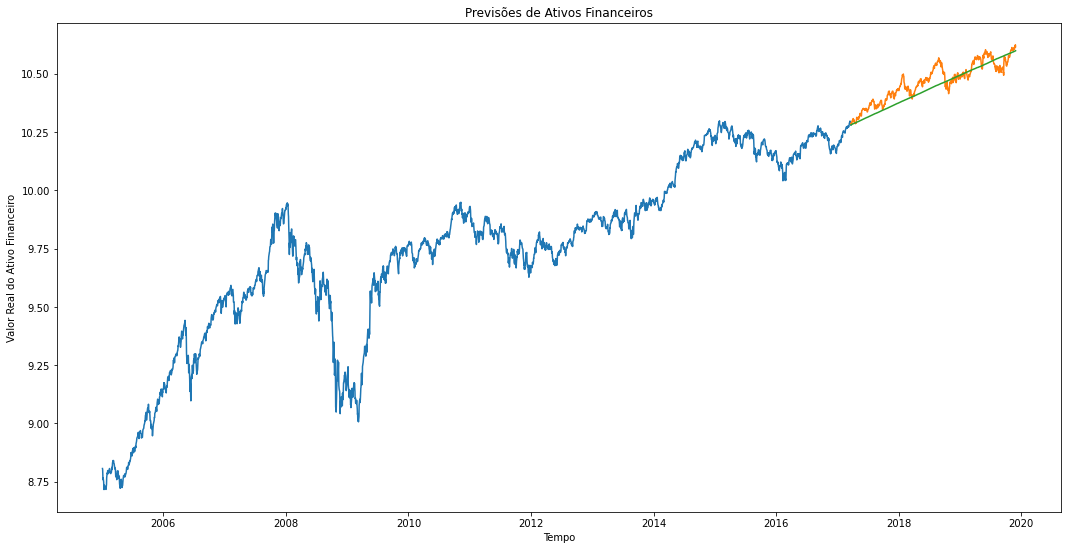

In [30]:
plt.figure(figsize = (18,9))
plt.plot(dados_treino_log, label = 'Dados de Treino')
plt.plot(dados_teste_log, label = 'Dados de Teste')
plt.plot(previsoes, label = 'Previsões')
plt.title('Previsões de Ativos Financeiros')
plt.xlabel('Tempo')
plt.ylabel('Valor Real do Ativo Financeiro')

O Erro Médio Absoluto em Percentual (MAPE):

$MAPE = \frac{1}{n} \sum_{i=1}^{n} \left|\frac{Atual - Previsto}{Atual}\right| \times 100$


In [31]:
def mape_arima(atual, pred):
    mask = atual != 0
    return np.mean(np.abs((atual[mask] - pred[mask]) / atual[mask])) * 100

In [32]:
rmse = np.sqrt(mean_squared_error(dados_teste_log, previsoes))
print(f"RMSE : {rmse}")

RMSE : 0.04419352752766801


In [33]:
dados_treino_log = dados_treino_log.to_frame(name='Close')
dados_teste_log = dados_teste_log.to_frame(name='Close')

atual = dados_teste_log['Close'].to_numpy()
pred = previsoes['Prediction'].to_numpy()

mape_sarima = mape_arima(atual, pred)
print(f'MAPE DO ARIMA: {mape_sarima:.2}%')

MAPE DO ARIMA: 0.35%


#### LSTM
- LSTMnet: define o modelo de Rede Neural com LSTM + as camadas densas
- forward: executa a previsão
- shaping: cria as janelas de dados temporais (sequências)
- objective: treina e avalia o modelo com a otimização optuna (baseada na otimização bayesiana, abordagem probabilística)

In [34]:
class LSTMnet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(DEVICE)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(DEVICE)
        _, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc2(self.relu(self.fc1(h_out)))
        return out

def shaping(data, n_input):
    X, y = [], []
    for i in range(n_input, len(data)):
        X.append(data[i - n_input:i])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    scaler = MinMaxScaler()
    train = dados_treino_log.copy()
    test = dados_teste_log.copy()

    scaler.fit(train.values.reshape(-1, 1))
    scaled_train = scaler.transform(train.values.reshape(-1, 1))
    scaled_test = scaler.transform(test.values.reshape(-1, 1))

    x_train, y_train = shaping(scaled_train, n_input)
    x_test, y_test = shaping(scaled_test, n_input)

    X_train = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
    X_test = torch.tensor(x_test, dtype=torch.float32).to(DEVICE)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

    model = LSTMnet(n_features, hidden_size, num_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(10):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        if output.shape != y_train.shape:
            return float("inf")
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_test)
        if pred.shape != y_test.shape:
            return float("inf")
        val_loss = criterion(pred, y_test).item()

    print(f"Trial {trial.number} | hidden_size={hidden_size} num_layers={num_layers} lr={lr:.6f} | Val Loss={val_loss:.6f}")
    return val_loss

In [35]:
%%time
prediction_window = 30
n_input = 30
n_features = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

best_params = study.best_params
print(f"Melhores hiperparâmetros encontrados: {best_params}")

EPOCHS = 1000
LEARNING_RATE = best_params["lr"]
HIDDEN_SIZE = best_params["hidden_size"]
NUM_LAYERS = best_params["num_layers"]

scaler = MinMaxScaler()
train = dados_treino_log.copy()
test = dados_teste_log.copy()

scaler.fit(train.values.reshape(-1, 1))
scaled_train = scaler.transform(train.values.reshape(-1, 1))
scaled_test = scaler.transform(test.values.reshape(-1, 1))

x_train, y_train = shaping(scaled_train, n_input)
x_test, y_test = shaping(scaled_test, n_input)

X_train = torch.tensor(x_train, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
X_test = torch.tensor(x_test, dtype=torch.float32).to(DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

model = LSTMnet(n_features, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

early_stopping_patience = 500
early_stopping_counter = 0
valid_loss_min = np.inf

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    train_loss = criterion(output, y_train)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        output_val = model(X_test)
        valid_loss = criterion(output_val, y_test)
        print(f"Epoch {epoch + 1} Train Loss: {train_loss.item():.6f} | Val Loss: {valid_loss.item():.6f}")
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './models/lstm_parte1.pt')
            valid_loss_min = valid_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        if early_stopping_counter > early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

Trial 7 | hidden_size=193 num_layers=1 lr=0.000123 | Val Loss=0.931402
Trial 10 | hidden_size=249 num_layers=1 lr=0.000100 | Val Loss=1.500532
Trial 11 | hidden_size=253 num_layers=1 lr=0.000139 | Val Loss=0.840905
Trial 12 | hidden_size=227 num_layers=1 lr=0.000128 | Val Loss=0.989116
Trial 13 | hidden_size=131 num_layers=1 lr=0.000073 | Val Loss=1.215335
Trial 14 | hidden_size=214 num_layers=1 lr=0.000274 | Val Loss=0.895030
Trial 15 | hidden_size=218 num_layers=1 lr=0.000253 | Val Loss=1.169729
Trial 16 | hidden_size=131 num_layers=1 lr=0.000041 | Val Loss=1.224539
Trial 17 | hidden_size=219 num_layers=1 lr=0.000398 | Val Loss=0.900275
Trial 18 | hidden_size=253 num_layers=1 lr=0.000416 | Val Loss=1.077998
Trial 19 | hidden_size=150 num_layers=1 lr=0.000031 | Val Loss=0.932595
Trial 21 | hidden_size=229 num_layers=1 lr=0.000518 | Val Loss=1.079461
Trial 22 | hidden_size=211 num_layers=1 lr=0.000702 | Val Loss=1.038418
Trial 23 | hidden_size=171 num_layers=1 lr=0.001688 | Val Loss=0.

Epoch 48 Train Loss: 0.016150 | Val Loss: 0.027125
Epoch 49 Train Loss: 0.015788 | Val Loss: 0.024436
Epoch 50 Train Loss: 0.014697 | Val Loss: 0.026435
Epoch 51 Train Loss: 0.013069 | Val Loss: 0.030916
Epoch 52 Train Loss: 0.011828 | Val Loss: 0.034206
Epoch 53 Train Loss: 0.011203 | Val Loss: 0.032340
Epoch 54 Train Loss: 0.010474 | Val Loss: 0.023813
Epoch 55 Train Loss: 0.009079 | Val Loss: 0.011796
Epoch 56 Train Loss: 0.007551 | Val Loss: 0.002972
Epoch 57 Train Loss: 0.006892 | Val Loss: 0.000429
Epoch 58 Train Loss: 0.006287 | Val Loss: 0.000501
Epoch 59 Train Loss: 0.004702 | Val Loss: 0.001385
Epoch 60 Train Loss: 0.004142 | Val Loss: 0.000512
Epoch 61 Train Loss: 0.003846 | Val Loss: 0.003073
Epoch 62 Train Loss: 0.002899 | Val Loss: 0.017414
Epoch 63 Train Loss: 0.003631 | Val Loss: 0.011674
Epoch 64 Train Loss: 0.002906 | Val Loss: 0.006480
Epoch 65 Train Loss: 0.003801 | Val Loss: 0.016667
Epoch 66 Train Loss: 0.003353 | Val Loss: 0.034696
Epoch 67 Train Loss: 0.004140 |

Epoch 207 Train Loss: 0.000414 | Val Loss: 0.001659
Epoch 208 Train Loss: 0.000412 | Val Loss: 0.001688
Epoch 209 Train Loss: 0.000411 | Val Loss: 0.001661
Epoch 210 Train Loss: 0.000410 | Val Loss: 0.001718
Epoch 211 Train Loss: 0.000409 | Val Loss: 0.001639
Epoch 212 Train Loss: 0.000408 | Val Loss: 0.001713
Epoch 213 Train Loss: 0.000407 | Val Loss: 0.001579
Epoch 214 Train Loss: 0.000406 | Val Loss: 0.001663
Epoch 215 Train Loss: 0.000404 | Val Loss: 0.001549
Epoch 216 Train Loss: 0.000401 | Val Loss: 0.001570
Epoch 217 Train Loss: 0.000399 | Val Loss: 0.001589
Epoch 218 Train Loss: 0.000398 | Val Loss: 0.001534
Epoch 219 Train Loss: 0.000398 | Val Loss: 0.001636
Epoch 220 Train Loss: 0.000397 | Val Loss: 0.001539
Epoch 221 Train Loss: 0.000396 | Val Loss: 0.001627
Epoch 222 Train Loss: 0.000394 | Val Loss: 0.001547
Epoch 223 Train Loss: 0.000391 | Val Loss: 0.001571
Epoch 224 Train Loss: 0.000389 | Val Loss: 0.001547
Epoch 225 Train Loss: 0.000388 | Val Loss: 0.001516
Epoch 226 Tr

Epoch 365 Train Loss: 0.000256 | Val Loss: 0.000825
Epoch 366 Train Loss: 0.000252 | Val Loss: 0.000890
Epoch 367 Train Loss: 0.000250 | Val Loss: 0.000862
Epoch 368 Train Loss: 0.000249 | Val Loss: 0.000841
Epoch 369 Train Loss: 0.000249 | Val Loss: 0.000892
Epoch 370 Train Loss: 0.000249 | Val Loss: 0.000797
Epoch 371 Train Loss: 0.000250 | Val Loss: 0.000922
Epoch 372 Train Loss: 0.000252 | Val Loss: 0.000746
Epoch 373 Train Loss: 0.000255 | Val Loss: 0.000969
Epoch 374 Train Loss: 0.000260 | Val Loss: 0.000681
Epoch 375 Train Loss: 0.000269 | Val Loss: 0.001051
Epoch 376 Train Loss: 0.000281 | Val Loss: 0.000618
Epoch 377 Train Loss: 0.000296 | Val Loss: 0.001142
Epoch 378 Train Loss: 0.000298 | Val Loss: 0.000651
Epoch 379 Train Loss: 0.000296 | Val Loss: 0.001147
Epoch 380 Train Loss: 0.000272 | Val Loss: 0.000850
Epoch 381 Train Loss: 0.000254 | Val Loss: 0.001041
Epoch 382 Train Loss: 0.000242 | Val Loss: 0.001083
Epoch 383 Train Loss: 0.000244 | Val Loss: 0.000864
Epoch 384 Tr

Epoch 523 Train Loss: 0.000225 | Val Loss: 0.000960
Epoch 524 Train Loss: 0.000196 | Val Loss: 0.000821
Epoch 525 Train Loss: 0.000216 | Val Loss: 0.001295
Epoch 526 Train Loss: 0.000231 | Val Loss: 0.000768
Epoch 527 Train Loss: 0.000219 | Val Loss: 0.000942
Epoch 528 Train Loss: 0.000196 | Val Loss: 0.000945
Epoch 529 Train Loss: 0.000203 | Val Loss: 0.000523
Epoch 530 Train Loss: 0.000227 | Val Loss: 0.000871
Epoch 531 Train Loss: 0.000231 | Val Loss: 0.000408
Epoch 532 Train Loss: 0.000235 | Val Loss: 0.000750
Epoch 533 Train Loss: 0.000224 | Val Loss: 0.000404
Epoch 534 Train Loss: 0.000219 | Val Loss: 0.000691
Epoch 535 Train Loss: 0.000213 | Val Loss: 0.000407
Epoch 536 Train Loss: 0.000213 | Val Loss: 0.000695
Epoch 537 Train Loss: 0.000215 | Val Loss: 0.000388
Epoch 538 Train Loss: 0.000223 | Val Loss: 0.000757
Epoch 539 Train Loss: 0.000234 | Val Loss: 0.000345
Epoch 540 Train Loss: 0.000255 | Val Loss: 0.000878
Epoch 541 Train Loss: 0.000272 | Val Loss: 0.000319
Epoch 542 Tr

In [36]:
model.load_state_dict(torch.load('./models/lstm_parte1.pt'))

model.eval()
with torch.no_grad():
    valid_predict = model(X_test.to(DEVICE))
    y_pred_scaled = valid_predict.cpu().data.numpy()

y_pred = scaler.inverse_transform(
    np.hstack((y_pred_scaled, np.zeros((y_pred_scaled.shape[0], scaled_train.shape[1] - 1))))
)[:, 0]

df_pred = test.iloc[n_input:len(y_pred) + n_input].copy()
df_pred['prediction'] = y_pred

In [37]:
def mape(atual, pred):
    mask = atual != 0
    atual_nonzero = atual[mask]
    pred_nonzero = pred[mask]
    return np.abs((atual_nonzero - pred_nonzero) / atual_nonzero).sum() / len(atual_nonzero) * 100

In [38]:
mape_lstm = mape(df_pred['Close'], df_pred['prediction'])
print(f'MAPE DO LSTM: {mape_lstm:.2}%')

rmse_lstm = np.sqrt(mean_squared_error(df_pred['Close'], df_pred['prediction']))
print(f"RMSE LSTM: {rmse_lstm}")

MAPE DO LSTM: 0.14%
RMSE LSTM: 0.018523080580625958


#### Adicionando variáveis exógenas
Série com as Notícias


Link do dataset: https://www.kaggle.com/datasets/therohk/india-headlines-news-dataset

In [39]:
columns = ['Date', 'Category', 'News']
df_news = pd.read_csv('datasets/india-news-headlines.csv', names = columns)

df_news.drop(0, inplace = True)
df_news.drop('Category', axis = 1, inplace = True)

display(df_news.head())
print()
display(df_news.tail())
df_news.shape

,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic


,Date,News
3424063,20201231,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,Covid-19: Despite dip in cases; Rajasthan amon...
3424066,20201231,Govt extends deadline for use of FASTag till F...
3424067,20201231,Celebs plan to party safely and responsibly on...


(3424067, 2)

In [40]:
df_news["Date"] = pd.to_datetime(df_news["Date"], format = '%Y%m%d')
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   News    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 52.2+ MB


Removendo os valores que não são letras

In [41]:
df_news.replace("[^a-zA-Z']", " ", regex = True, inplace = True)
df_news["News"].head()

1    Status quo will not be disturbed at Ayodhya  s...
2                  Fissures in Hurriyat over Pak visit
3                America's unwanted heading for India 
4                   For bigwigs  it is destination Goa
5                 Extra buses to clear tourist traffic
Name: News, dtype: object

Agrupmaneto do total de manchetes de notícias para cada dia, remover duplicatas e fazer o reset do índice

In [42]:
%%time
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)

CPU times: total: 3min 24s
Wall time: 3min 24s


In [43]:
df_news.to_csv('datasets/df_news_agrupado.csv', index=False)
df = pd.read_csv('datasets/df_news_agrupado.csv')

Utilizei o vader_lexicon para poder extrair sentimentos em textos curtos e com nuances que geralmente são encontradas em redes sociais, comentários e reviews.


Outro ponto é a capacidade de capturar a intensidade do sentimento atribuindo pontuações por meio do atributo Compound (-1 indica muito negativo, 1 indica muito positivo e 0 é neutro). Aliado da subjetividade posso separar também opiniões pessoais de comentários mais objetivos e extrair insights

In [44]:
# Função para obter subjetividade
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Função para obter polaridade
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['News'].apply(getSubjectivity)
df['Polarity'] = df['News'].apply(getPolarity)

# Criando o analisador de sentimento
analyser = SentimentIntensityAnalyzer()

In [45]:
%%time
df['Compound'] = [analyser.polarity_scores(v)['compound'] for v in df['News']]
df['Negative'] = [analyser.polarity_scores(v)['neg'] for v in df['News']]
df['Neutral']  = [analyser.polarity_scores(v)['neu'] for v in df['News']]
df['Positive'] = [analyser.polarity_scores(v)['pos'] for v in df['News']]

df.head()

CPU times: total: 49min 2s
Wall time: 49min 10s


,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.121,0.809,0.071
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.156,0.735,0.109
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.792,0.104
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.142,0.694,0.164
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.214,0.655,0.131


#### Salvando o dataframe como checkpoint

In [46]:
df.to_csv('datasets/df_news_checkpoint.csv', index=False)
# df = pd.read_csv('datasets/df_news_checkpoint.csv')

df['Date'] = pd.to_datetime(df['Date'])

#### Criando os Datasets Para Treino dos Modelos

In [47]:
df_bsesn = df_bsesn.reset_index()

In [48]:
df_merge = pd.merge(df_bsesn, df, how='left', on='Date')

In [49]:
df_merge.head(1)

,Date,Close,High,Low,Open,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2005-01-03,6679.200195,6684.220215,6626.490234,6626.490234,12000,ICAI compliments minister Partnering for futur...,0.398414,0.0667,-0.9972,0.19,0.696,0.114


In [50]:
# Variáveis que serão usadas para treinar os modelos
df_merge1 = df_merge[['Close',
                      'Subjectivity',
                      'Polarity',
                      'Compound', 
                      'Negative', 
                      'Neutral', 
                      'Positive']]

In [51]:
df_merge1.head(3)

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,6679.200195,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,6651.009766,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,6458.839844,0.422979,0.084374,-0.9947,0.149,0.749,0.103


In [52]:
df_time_series = df_merge1['Close']

In [53]:
exog_data = df_merge1[['Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive']]
exog_data.head(3)

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,0.422979,0.084374,-0.9947,0.149,0.749,0.103


In [54]:
final_train_data = df_time_series[:3000]
exog_train_data = exog_data[:3000]

In [55]:
final_test_data = df_time_series[3000:]
exog_test_data = exog_data[3000:]

In [56]:
X = df_merge1.drop('Close', axis = 1)
X

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.398414,0.066700,-0.9972,0.190,0.696,0.114
1,0.374999,0.071855,-0.9516,0.095,0.837,0.068
2,0.422979,0.084374,-0.9947,0.149,0.749,0.103
3,0.329153,0.169928,0.0262,0.101,0.799,0.101
4,0.450775,0.061027,-0.9958,0.139,0.772,0.088
...,...,...,...,...,...,...
3654,0.367645,0.051117,-0.9998,0.138,0.780,0.081
3655,0.384087,0.049062,-0.9999,0.163,0.750,0.087
3656,0.404191,0.051030,-0.9999,0.160,0.749,0.091
3657,0.397646,0.065572,-0.9998,0.121,0.812,0.068


In [57]:
Y = df_merge1['Close']
Y

0        6679.200195
1        6651.009766
2        6458.839844
3        6367.390137
4        6420.459961
            ...     
3654    40889.230469
3655    40821.300781
3656    41020.609375
3657    41130.171875
3658    40793.808594
Name: Close, Length: 3659, dtype: float64

#### Sarimax
Variáveis exógenas

In [58]:
modelo_sarimax = SARIMAX(final_train_data,
                         exog = exog_train_data,
                         order = (1, 1, 1),
                         seasonal_order = (0, 0, 0, 0))

In [59]:
resultado = modelo_sarimax.fit()

In [60]:
forecast = resultado.forecast(10, exog = exog_test_data[:10])

In [61]:
exog_train_data.tail()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
2995,0.380927,0.053486,-0.9999,0.149,0.747,0.103
2996,0.414204,0.078247,-0.9999,0.154,0.754,0.093
2997,0.390177,0.066918,-0.9996,0.133,0.757,0.110
2998,0.375400,0.042492,-0.9999,0.140,0.766,0.093
2999,0.391797,0.045332,-1.0000,0.178,0.728,0.095


In [62]:
forecast

3000    29138.425503
3001    29148.931011
3002    29144.681389
3003    29157.405779
3004    29149.746077
3005    29143.035322
3006    29155.652859
3007    29147.966133
3008    29143.991959
3009    29149.255636
Name: predicted_mean, dtype: float64

In [64]:
y_true = final_test_data[:10]
y_pred = forecast.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

mape_sarima = mape_arima(np.array(y_true), np.array(y_pred))
print(f"MAPE DO ARIMA: {mape_sarima:.2} %")

RMSE: 517.2825986633601
MAPE DO ARIMA: 1.5 %


### Redes Neurais LSTM Parte 2

In [65]:
df_merge1.head(1)

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,6679.200195,0.398414,0.0667,-0.9972,0.19,0.696,0.114


In [66]:
prediction_window = 30
n_input = 30
n_features = df_merge1.shape[1]
train = df_merge1.iloc[:-90].copy()
test = df_merge1.iloc[-90:].copy()
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

def shaping(data, n_input):
    X_train = []
    y_train = []
    for i in range(n_input, len(data)):
        X_train.append(data[i - n_input:i, :])
        y_train.append(data[i, 0])
    return np.array(X_train), np.array(y_train)

x_train, y_train = shaping(scaled_train, prediction_window)
x_test, y_test = shaping(scaled_test, prediction_window)
X_train = Variable(torch.Tensor(x_train))
y_train = Variable(torch.Tensor(y_train).unsqueeze(1))
X_test = Variable(torch.Tensor(x_test))
y_test = Variable(torch.Tensor(y_test).unsqueeze(1))

class LSTMnet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMnet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 40)
        self.fc2 = nn.Linear(40, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        _, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc2(self.relu(self.fc1(h_out)))
        return out

EPOCHS = 2000
LEARNING_RATE = 0.008
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
INPUT_SIZE = n_features
HIDDEN_SIZE = 100
NUM_LAYERS = 1
model = LSTMnet(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
model.to(DEVICE)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopping_patience = 500
early_stopping_counter = 0
valid_loss_min = np.inf


for epoch in range(EPOCHS):
    optimizer.zero_grad()
    model.train()
    output = model(X_train)
    train_loss = criterion(output, y_train)
    train_loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        output_val = model(X_test)
        valid_loss = criterion(output_val, y_test)
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), './models/lstm_parte2.pt')
            print(f'Epoch {epoch + 1}: Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')            
            valid_loss_min = valid_loss
            early_stopping_counter = 0
        else:
            print(f'Epoch {epoch + 1}: Validation loss did not decrease')
            early_stopping_counter += 1
        if early_stopping_counter > early_stopping_patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    print(f'Epoch {epoch + 1} Train Loss: {train_loss:.4f} Validation Loss:{valid_loss:.4f}')

Epoch 1: Validation loss decreased (inf --> 0.670456). Saving model ...
Epoch 1 Train Loss: 0.2402 Validation Loss:0.6705
Epoch 2: Validation loss decreased (0.670456 --> 0.350305). Saving model ...
Epoch 2 Train Loss: 0.1474 Validation Loss:0.3503
Epoch 3: Validation loss decreased (0.350305 --> 0.054576). Saving model ...
Epoch 3 Train Loss: 0.0609 Validation Loss:0.0546
Epoch 4: Validation loss did not decrease
Epoch 4 Train Loss: 0.5937 Validation Loss:0.1216
Epoch 5: Validation loss did not decrease
Epoch 5 Train Loss: 0.0691 Validation Loss:0.4280
Epoch 6: Validation loss did not decrease
Epoch 6 Train Loss: 0.0759 Validation Loss:0.5597
Epoch 7: Validation loss did not decrease
Epoch 7 Train Loss: 0.1109 Validation Loss:0.6042
Epoch 8: Validation loss did not decrease
Epoch 8 Train Loss: 0.1245 Validation Loss:0.6072
Epoch 9: Validation loss did not decrease
Epoch 9 Train Loss: 0.1253 Validation Loss:0.5879
Epoch 10: Validation loss did not decrease
Epoch 10 Train Loss: 0.1189 V

Epoch 87: Validation loss did not decrease
Epoch 87 Train Loss: 0.0003 Validation Loss:0.0012
Epoch 88: Validation loss did not decrease
Epoch 88 Train Loss: 0.0003 Validation Loss:0.0019
Epoch 89: Validation loss did not decrease
Epoch 89 Train Loss: 0.0002 Validation Loss:0.0027
Epoch 90: Validation loss did not decrease
Epoch 90 Train Loss: 0.0003 Validation Loss:0.0029
Epoch 91: Validation loss did not decrease
Epoch 91 Train Loss: 0.0003 Validation Loss:0.0024
Epoch 92: Validation loss did not decrease
Epoch 92 Train Loss: 0.0003 Validation Loss:0.0017
Epoch 93: Validation loss did not decrease
Epoch 93 Train Loss: 0.0003 Validation Loss:0.0014
Epoch 94: Validation loss did not decrease
Epoch 94 Train Loss: 0.0002 Validation Loss:0.0014
Epoch 95: Validation loss did not decrease
Epoch 95 Train Loss: 0.0002 Validation Loss:0.0013
Epoch 96: Validation loss did not decrease
Epoch 96 Train Loss: 0.0002 Validation Loss:0.0010
Epoch 97: Validation loss did not decrease
Epoch 97 Train Lo

Epoch 169: Validation loss decreased (0.000406 --> 0.000405). Saving model ...
Epoch 169 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 170: Validation loss decreased (0.000405 --> 0.000401). Saving model ...
Epoch 170 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 171: Validation loss decreased (0.000401 --> 0.000394). Saving model ...
Epoch 171 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 172: Validation loss decreased (0.000394 --> 0.000391). Saving model ...
Epoch 172 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 173: Validation loss did not decrease
Epoch 173 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 174: Validation loss did not decrease
Epoch 174 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 175: Validation loss did not decrease
Epoch 175 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 176: Validation loss decreased (0.000391 --> 0.000389). Saving model ...
Epoch 176 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 177: Validation loss decreased (0.000389 --> 0.0003

Epoch 236: Validation loss decreased (0.000338 --> 0.000337). Saving model ...
Epoch 236 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 237: Validation loss decreased (0.000337 --> 0.000337). Saving model ...
Epoch 237 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 238: Validation loss decreased (0.000337 --> 0.000336). Saving model ...
Epoch 238 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 239: Validation loss decreased (0.000336 --> 0.000335). Saving model ...
Epoch 239 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 240: Validation loss decreased (0.000335 --> 0.000334). Saving model ...
Epoch 240 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 241: Validation loss decreased (0.000334 --> 0.000333). Saving model ...
Epoch 241 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 242: Validation loss decreased (0.000333 --> 0.000332). Saving model ...
Epoch 242 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 243: Validation loss decreased (0.000332 --> 0.000331). Saving model ...
Epoc

Epoch 299: Validation loss decreased (0.000295 --> 0.000294). Saving model ...
Epoch 299 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 300: Validation loss decreased (0.000294 --> 0.000294). Saving model ...
Epoch 300 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 301: Validation loss decreased (0.000294 --> 0.000293). Saving model ...
Epoch 301 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 302: Validation loss decreased (0.000293 --> 0.000293). Saving model ...
Epoch 302 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 303: Validation loss decreased (0.000293 --> 0.000293). Saving model ...
Epoch 303 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 304: Validation loss decreased (0.000293 --> 0.000292). Saving model ...
Epoch 304 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 305: Validation loss decreased (0.000292 --> 0.000292). Saving model ...
Epoch 305 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 306: Validation loss decreased (0.000292 --> 0.000291). Saving model ...
Epoc

Epoch 362: Validation loss decreased (0.000276 --> 0.000275). Saving model ...
Epoch 362 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 363: Validation loss decreased (0.000275 --> 0.000275). Saving model ...
Epoch 363 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 364: Validation loss decreased (0.000275 --> 0.000274). Saving model ...
Epoch 364 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 365: Validation loss decreased (0.000274 --> 0.000274). Saving model ...
Epoch 365 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 366: Validation loss decreased (0.000274 --> 0.000274). Saving model ...
Epoch 366 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 367: Validation loss decreased (0.000274 --> 0.000273). Saving model ...
Epoch 367 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 368: Validation loss decreased (0.000273 --> 0.000273). Saving model ...
Epoch 368 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 369: Validation loss decreased (0.000273 --> 0.000273). Saving model ...
Epoc

Epoch 425: Validation loss decreased (0.000263 --> 0.000263). Saving model ...
Epoch 425 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 426: Validation loss decreased (0.000263 --> 0.000263). Saving model ...
Epoch 426 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 427: Validation loss decreased (0.000263 --> 0.000263). Saving model ...
Epoch 427 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 428: Validation loss decreased (0.000263 --> 0.000262). Saving model ...
Epoch 428 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 429: Validation loss did not decrease
Epoch 429 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 430: Validation loss decreased (0.000262 --> 0.000262). Saving model ...
Epoch 430 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 431: Validation loss decreased (0.000262 --> 0.000262). Saving model ...
Epoch 431 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 432: Validation loss did not decrease
Epoch 432 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 433: Validation 

Epoch 492: Validation loss decreased (0.000257 --> 0.000256). Saving model ...
Epoch 492 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 493: Validation loss did not decrease
Epoch 493 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 494: Validation loss decreased (0.000256 --> 0.000256). Saving model ...
Epoch 494 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 495: Validation loss decreased (0.000256 --> 0.000256). Saving model ...
Epoch 495 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 496: Validation loss did not decrease
Epoch 496 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 497: Validation loss decreased (0.000256 --> 0.000256). Saving model ...
Epoch 497 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 498: Validation loss did not decrease
Epoch 498 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 499: Validation loss decreased (0.000256 --> 0.000255). Saving model ...
Epoch 499 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 500: Validation loss decreased (0.000255 --> 0.0002

Epoch 571: Validation loss decreased (0.000237 --> 0.000236). Saving model ...
Epoch 571 Train Loss: 0.0005 Validation Loss:0.0002
Epoch 572: Validation loss did not decrease
Epoch 572 Train Loss: 0.0002 Validation Loss:0.0002
Epoch 573: Validation loss did not decrease
Epoch 573 Train Loss: 0.0001 Validation Loss:0.0010
Epoch 574: Validation loss did not decrease
Epoch 574 Train Loss: 0.0004 Validation Loss:0.0006
Epoch 575: Validation loss did not decrease
Epoch 575 Train Loss: 0.0004 Validation Loss:0.0006
Epoch 576: Validation loss did not decrease
Epoch 576 Train Loss: 0.0002 Validation Loss:0.0004
Epoch 577: Validation loss did not decrease
Epoch 577 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 578: Validation loss did not decrease
Epoch 578 Train Loss: 0.0002 Validation Loss:0.0008
Epoch 579: Validation loss did not decrease
Epoch 579 Train Loss: 0.0002 Validation Loss:0.0002
Epoch 580: Validation loss did not decrease
Epoch 580 Train Loss: 0.0001 Validation Loss:0.0003
Epoch

Epoch 655: Validation loss did not decrease
Epoch 655 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 656: Validation loss did not decrease
Epoch 656 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 657: Validation loss did not decrease
Epoch 657 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 658: Validation loss did not decrease
Epoch 658 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 659: Validation loss did not decrease
Epoch 659 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 660: Validation loss did not decrease
Epoch 660 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 661: Validation loss did not decrease
Epoch 661 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 662: Validation loss did not decrease
Epoch 662 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 663: Validation loss did not decrease
Epoch 663 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 664: Validation loss did not decrease
Epoch 664 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 665: Validation loss did not decre

Epoch 741: Validation loss did not decrease
Epoch 741 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 742: Validation loss did not decrease
Epoch 742 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 743: Validation loss did not decrease
Epoch 743 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 744: Validation loss did not decrease
Epoch 744 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 745: Validation loss did not decrease
Epoch 745 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 746: Validation loss did not decrease
Epoch 746 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 747: Validation loss did not decrease
Epoch 747 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 748: Validation loss did not decrease
Epoch 748 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 749: Validation loss did not decrease
Epoch 749 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 750: Validation loss did not decrease
Epoch 750 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 751: Validation loss did not decre

Epoch 811: Validation loss did not decrease
Epoch 811 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 812: Validation loss decreased (0.000226 --> 0.000225). Saving model ...
Epoch 812 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 813: Validation loss did not decrease
Epoch 813 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 814: Validation loss did not decrease
Epoch 814 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 815: Validation loss did not decrease
Epoch 815 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 816: Validation loss did not decrease
Epoch 816 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 817: Validation loss did not decrease
Epoch 817 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 818: Validation loss did not decrease
Epoch 818 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 819: Validation loss did not decrease
Epoch 819 Train Loss: 0.0001 Validation Loss:0.0005
Epoch 820: Validation loss did not decrease
Epoch 820 Train Loss: 0.0002 Validation Loss:0.0005
Epoch

Epoch 894: Validation loss did not decrease
Epoch 894 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 895: Validation loss did not decrease
Epoch 895 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 896: Validation loss did not decrease
Epoch 896 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 897: Validation loss did not decrease
Epoch 897 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 898: Validation loss did not decrease
Epoch 898 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 899: Validation loss did not decrease
Epoch 899 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 900: Validation loss did not decrease
Epoch 900 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 901: Validation loss did not decrease
Epoch 901 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 902: Validation loss did not decrease
Epoch 902 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 903: Validation loss did not decrease
Epoch 903 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 904: Validation loss did not decre

Epoch 974: Validation loss decreased (0.000217 --> 0.000217). Saving model ...
Epoch 974 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 975: Validation loss did not decrease
Epoch 975 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 976: Validation loss decreased (0.000217 --> 0.000217). Saving model ...
Epoch 976 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 977: Validation loss did not decrease
Epoch 977 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 978: Validation loss decreased (0.000217 --> 0.000217). Saving model ...
Epoch 978 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 979: Validation loss did not decrease
Epoch 979 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 980: Validation loss decreased (0.000217 --> 0.000217). Saving model ...
Epoch 980 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 981: Validation loss decreased (0.000217 --> 0.000217). Saving model ...
Epoch 981 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 982: Validation loss decreased (0.000217 --> 0.0002

Epoch 1046: Validation loss did not decrease
Epoch 1046 Train Loss: 0.0001 Validation Loss:0.0007
Epoch 1047: Validation loss did not decrease
Epoch 1047 Train Loss: 0.0003 Validation Loss:0.0005
Epoch 1048: Validation loss did not decrease
Epoch 1048 Train Loss: 0.0003 Validation Loss:0.0004
Epoch 1049: Validation loss did not decrease
Epoch 1049 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1050: Validation loss did not decrease
Epoch 1050 Train Loss: 0.0001 Validation Loss:0.0006
Epoch 1051: Validation loss did not decrease
Epoch 1051 Train Loss: 0.0002 Validation Loss:0.0003
Epoch 1052: Validation loss did not decrease
Epoch 1052 Train Loss: 0.0002 Validation Loss:0.0003
Epoch 1053: Validation loss did not decrease
Epoch 1053 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 1054: Validation loss did not decrease
Epoch 1054 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 1055: Validation loss did not decrease
Epoch 1055 Train Loss: 0.0002 Validation Loss:0.0003
Epoch 1056: Validati

Epoch 1127: Validation loss did not decrease
Epoch 1127 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1128: Validation loss did not decrease
Epoch 1128 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1129: Validation loss did not decrease
Epoch 1129 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1130: Validation loss did not decrease
Epoch 1130 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1131: Validation loss did not decrease
Epoch 1131 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1132: Validation loss did not decrease
Epoch 1132 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1133: Validation loss did not decrease
Epoch 1133 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1134: Validation loss did not decrease
Epoch 1134 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1135: Validation loss did not decrease
Epoch 1135 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1136: Validation loss did not decrease
Epoch 1136 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1137: Validati

Epoch 1202: Validation loss decreased (0.000200 --> 0.000200). Saving model ...
Epoch 1202 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1203: Validation loss did not decrease
Epoch 1203 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1204: Validation loss decreased (0.000200 --> 0.000200). Saving model ...
Epoch 1204 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1205: Validation loss decreased (0.000200 --> 0.000200). Saving model ...
Epoch 1205 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1206: Validation loss decreased (0.000200 --> 0.000200). Saving model ...
Epoch 1206 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1207: Validation loss decreased (0.000200 --> 0.000200). Saving model ...
Epoch 1207 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1208: Validation loss did not decrease
Epoch 1208 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1209: Validation loss decreased (0.000200 --> 0.000200). Saving model ...
Epoch 1209 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 

Epoch 1269: Validation loss decreased (0.000197 --> 0.000197). Saving model ...
Epoch 1269 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1270: Validation loss did not decrease
Epoch 1270 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1271: Validation loss decreased (0.000197 --> 0.000197). Saving model ...
Epoch 1271 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1272: Validation loss did not decrease
Epoch 1272 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1273: Validation loss decreased (0.000197 --> 0.000197). Saving model ...
Epoch 1273 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1274: Validation loss did not decrease
Epoch 1274 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1275: Validation loss decreased (0.000197 --> 0.000196). Saving model ...
Epoch 1275 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1276: Validation loss decreased (0.000196 --> 0.000196). Saving model ...
Epoch 1276 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1277: Validation loss decreased (0.

Epoch 1341: Validation loss did not decrease
Epoch 1341 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 1342: Validation loss did not decrease
Epoch 1342 Train Loss: 0.0002 Validation Loss:0.0004
Epoch 1343: Validation loss did not decrease
Epoch 1343 Train Loss: 0.0002 Validation Loss:0.0004
Epoch 1344: Validation loss did not decrease
Epoch 1344 Train Loss: 0.0002 Validation Loss:0.0002
Epoch 1345: Validation loss did not decrease
Epoch 1345 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1346: Validation loss did not decrease
Epoch 1346 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1347: Validation loss did not decrease
Epoch 1347 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 1348: Validation loss did not decrease
Epoch 1348 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 1349: Validation loss did not decrease
Epoch 1349 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1350: Validation loss did not decrease
Epoch 1350 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1351: Validati

Epoch 1422: Validation loss did not decrease
Epoch 1422 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1423: Validation loss did not decrease
Epoch 1423 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1424: Validation loss did not decrease
Epoch 1424 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1425: Validation loss did not decrease
Epoch 1425 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1426: Validation loss did not decrease
Epoch 1426 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1427: Validation loss did not decrease
Epoch 1427 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1428: Validation loss did not decrease
Epoch 1428 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1429: Validation loss did not decrease
Epoch 1429 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1430: Validation loss did not decrease
Epoch 1430 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1431: Validation loss did not decrease
Epoch 1431 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1432: Validati

Epoch 1495: Validation loss decreased (0.000178 --> 0.000177). Saving model ...
Epoch 1495 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1496: Validation loss did not decrease
Epoch 1496 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1497: Validation loss decreased (0.000177 --> 0.000176). Saving model ...
Epoch 1497 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1498: Validation loss did not decrease
Epoch 1498 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1499: Validation loss did not decrease
Epoch 1499 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1500: Validation loss did not decrease
Epoch 1500 Train Loss: 0.0001 Validation Loss:0.0003
Epoch 1501: Validation loss did not decrease
Epoch 1501 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1502: Validation loss did not decrease
Epoch 1502 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 1503: Validation loss did not decrease
Epoch 1503 Train Loss: 0.0001 Validation Loss:0.0004
Epoch 1504: Validation loss did not decrease
Epo

Epoch 1576: Validation loss did not decrease
Epoch 1576 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1577: Validation loss did not decrease
Epoch 1577 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1578: Validation loss did not decrease
Epoch 1578 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1579: Validation loss did not decrease
Epoch 1579 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1580: Validation loss did not decrease
Epoch 1580 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1581: Validation loss did not decrease
Epoch 1581 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1582: Validation loss did not decrease
Epoch 1582 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1583: Validation loss did not decrease
Epoch 1583 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1584: Validation loss did not decrease
Epoch 1584 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1585: Validation loss did not decrease
Epoch 1585 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1586: Validati

Epoch 1658: Validation loss did not decrease
Epoch 1658 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1659: Validation loss decreased (0.000170 --> 0.000169). Saving model ...
Epoch 1659 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1660: Validation loss did not decrease
Epoch 1660 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1661: Validation loss decreased (0.000169 --> 0.000169). Saving model ...
Epoch 1661 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1662: Validation loss decreased (0.000169 --> 0.000169). Saving model ...
Epoch 1662 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1663: Validation loss did not decrease
Epoch 1663 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1664: Validation loss decreased (0.000169 --> 0.000169). Saving model ...
Epoch 1664 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1665: Validation loss decreased (0.000169 --> 0.000169). Saving model ...
Epoch 1665 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1666: Validation loss decreased (0.

Epoch 1727: Validation loss did not decrease
Epoch 1727 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1728: Validation loss did not decrease
Epoch 1728 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1729: Validation loss did not decrease
Epoch 1729 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1730: Validation loss did not decrease
Epoch 1730 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1731: Validation loss did not decrease
Epoch 1731 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1732: Validation loss did not decrease
Epoch 1732 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1733: Validation loss did not decrease
Epoch 1733 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1734: Validation loss did not decrease
Epoch 1734 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1735: Validation loss did not decrease
Epoch 1735 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1736: Validation loss did not decrease
Epoch 1736 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1737: Validati

Epoch 1806: Validation loss decreased (0.000165 --> 0.000165). Saving model ...
Epoch 1806 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1807: Validation loss did not decrease
Epoch 1807 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1808: Validation loss decreased (0.000165 --> 0.000165). Saving model ...
Epoch 1808 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1809: Validation loss did not decrease
Epoch 1809 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1810: Validation loss decreased (0.000165 --> 0.000165). Saving model ...
Epoch 1810 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1811: Validation loss did not decrease
Epoch 1811 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1812: Validation loss decreased (0.000165 --> 0.000164). Saving model ...
Epoch 1812 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1813: Validation loss did not decrease
Epoch 1813 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1814: Validation loss decreased (0.000164 --> 0.000164). Saving model 

Epoch 1885: Validation loss did not decrease
Epoch 1885 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1886: Validation loss did not decrease
Epoch 1886 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1887: Validation loss did not decrease
Epoch 1887 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1888: Validation loss did not decrease
Epoch 1888 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1889: Validation loss did not decrease
Epoch 1889 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1890: Validation loss did not decrease
Epoch 1890 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1891: Validation loss did not decrease
Epoch 1891 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1892: Validation loss did not decrease
Epoch 1892 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1893: Validation loss did not decrease
Epoch 1893 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1894: Validation loss did not decrease
Epoch 1894 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1895: Validati

Epoch 1969: Validation loss did not decrease
Epoch 1969 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1970: Validation loss did not decrease
Epoch 1970 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1971: Validation loss did not decrease
Epoch 1971 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1972: Validation loss did not decrease
Epoch 1972 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1973: Validation loss did not decrease
Epoch 1973 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1974: Validation loss did not decrease
Epoch 1974 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1975: Validation loss did not decrease
Epoch 1975 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1976: Validation loss did not decrease
Epoch 1976 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1977: Validation loss did not decrease
Epoch 1977 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1978: Validation loss did not decrease
Epoch 1978 Train Loss: 0.0001 Validation Loss:0.0002
Epoch 1979: Validati

In [67]:
model = LSTMnet(n_features, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
model.load_state_dict(torch.load('./models/lstm_parte2.pt'))

model.eval()
valid_predict = model(X_test)
y_pred_scaled = valid_predict.data.cpu().numpy()

y_pred = scaler.inverse_transform(
    np.hstack((y_pred_scaled, np.zeros((y_pred_scaled.shape[0], train.shape[1] - 1))))
)[:, 0]

df_pred = test.iloc[:len(y_pred)].copy()
df_pred['prediction'] = y_pred

In [68]:
df_pred.tail()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,prediction
3624,38177.949219,0.426521,0.082447,-0.9999,0.161,0.743,0.095,40433.382881
3625,37880.398438,0.411334,0.033530,-0.9999,0.155,0.750,0.095,40794.971651
3626,38127.078125,0.375459,0.076294,-0.9999,0.148,0.769,0.083,40909.347284
3627,38214.468750,0.434589,0.021162,-1.0000,0.187,0.728,0.085,41054.623032
3628,38506.089844,0.375814,0.052802,-0.9999,0.169,0.747,0.084,41206.565906


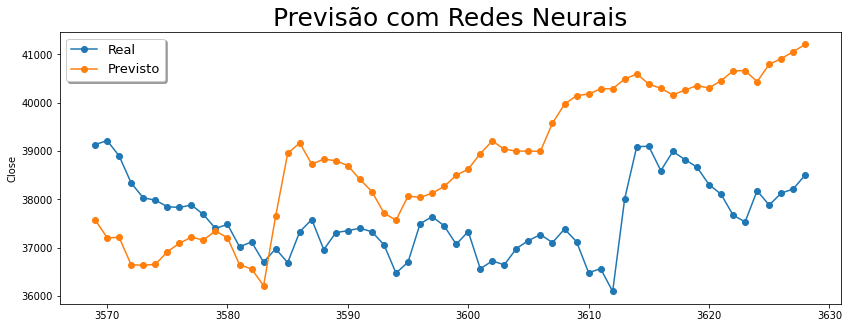

In [69]:
plt.figure(figsize=(14,5))
plt.plot(df_pred['Close'], label='Real', marker='o')
plt.plot(df_pred['prediction'], label='Previsto', marker='o')
plt.title('Previsão com Redes Neurais', fontsize=25)
plt.ylabel('Close')
plt.legend(title_fontsize=14, fontsize=13, fancybox=True, shadow=True, frameon=True)
fig = plt.gcf()
plt.show()

In [70]:
mape_lstm = mape(df_pred['Close'], df_pred['prediction'])
print(f'MAPE OF LSTM MODEL : {mape_lstm:.2%}')

rmse_lstm = np.sqrt(mean_squared_error(df_pred['Close'], df_pred['prediction']))
print(f"RMSE LSTM: {rmse_lstm}")

MAPE OF LSTM MODEL : 453.66%
RMSE LSTM: 1940.161417304201
